# **Geopolitical risk uncertainty and oil future volatility: Evidence from MIDAS models**

**Etapes** :
- Création de mesures de volatité et décomposition de l'indice GPR
- Estimation et prédictions avec les modèles MIDAS à différents horizons
- Evaluation des résultats via affichage de la HMSE, HMAE et p-values des tests MCS de comparaison des modèles 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.volatility_measures import RealizedVolatilityMeasure
from src.gpr_measures import GPRDecomposer
from src.midas_models import MIDASModel
from src.model_evaluation import ModelEvaluation

## Importation des données

Data E-mini Crude Oil Futures

In [4]:
df_oil = pd.read_csv('data/raw/E-mini Crude Oil Futures_2007_2025.csv', delimiter=',', decimal=',')
df_oil['Date'] = pd.to_datetime(df_oil['Date'], format='%d/%m/%Y')
df_oil.index = df_oil['Date']
df_oil.drop(columns=['Date'], inplace = True)
df_oil.head()

,Dernier,Ouv.,Plus Haut,Plus Bas,Vol.,Variation %
Date,,,,,,
2007-01-02,61.05,61.02,61.52,60.40,"6,34K","0,00%"
2007-01-03,58.32,60.90,60.98,57.73,"30,41K","-4,47%"
2007-01-04,55.59,58.38,58.58,55.38,"47,25K","-4,68%"
2007-01-05,56.31,55.50,56.38,54.90,"34,39K","1,30%"
2007-01-08,56.09,56.27,57.70,55.12,"44,13K","-0,39%"


Data indice GPR

In [5]:
df_gpr = pd.read_excel('data/raw/data_gpr_daily_recent.xls', usecols=range(9))
df_gpr['DAY'] = pd.to_datetime(df_gpr['DAY'], format='%Y%m%d')
df_gpr.index = df_gpr['DAY']
df_gpr.drop(columns=['DAY'], inplace = True)
print('len(df_gpr) :', len(df_gpr))

len(df_gpr) : 14693


## Mesures de volatilité

In [6]:
rv_measure = RealizedVolatilityMeasure(df_oil)

# calcule de toutes les mesures de volatilité
df_volatility = rv_measure.all_volatility_measures(alpha=0.05)
# df_volatility.to_csv('data/result/volatility_data.csv')
# df_volatility = pd.read_csv('data/result/volatility_data.csv', index_col = 0)
df_volatility.head()


,rv,rv_pos,rv_neg,bpv,tq,z_ratio,is_jump,crv,cj
Date,,,,,,,,,
2007-01-31,0.021207,0.010111,0.011096,NaN,NaN,NaN,False,0.021207,0.000000
2007-02-28,0.007479,0.004514,0.002966,0.006401,1.320185e-06,1.631289,False,0.007479,0.000000
2007-03-31,0.008073,0.005943,0.002130,0.004338,7.012901e-07,5.235647,True,0.004338,0.003735
2007-04-30,0.004605,0.002572,0.002033,0.003712,7.108400e-07,2.194892,True,0.003712,0.000893
2007-05-31,0.005467,0.002533,0.002934,0.003742,4.115325e-07,3.571054,True,0.003742,0.001725


Visualisation

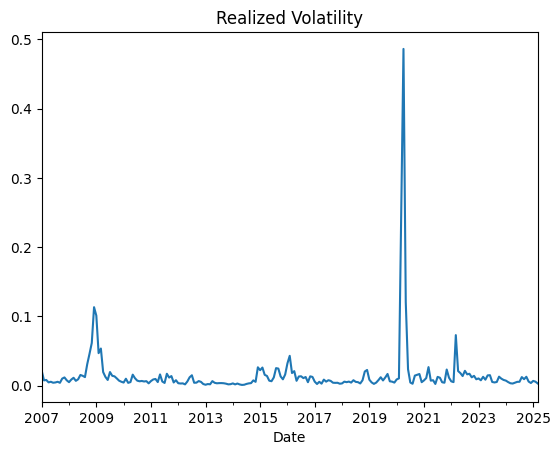

<Figure size 800x500 with 0 Axes>

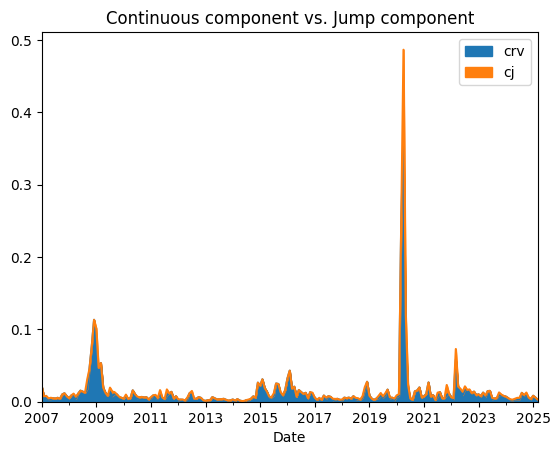

In [7]:
# rv
df_volatility['rv'].plot(title='Realized Volatility')
plt.show()

# crv x cj
plt.figure(figsize=(8, 5))
df_volatility[['crv', 'cj']].plot(kind='area', stacked=True)
plt.title('Continuous component vs. Jump component')
plt.show()

## Décomposition de l'indice GPR

In [8]:
decomposer = GPRDecomposer()
df_gpr_augmente = decomposer.fit_transform(df_gpr['GPRD'])

c:\Users\lebre\OneDrive\Bureau\Econo_fi\projet_eco_fi\.venv_midas\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lebre\OneDrive\Bureau\Econo_fi\projet_eco_fi\src\gpr_measures.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.v1 = self.results.params[0]
c:\Users\lebre\OneDrive\Bureau\Econo_fi\projet_eco_fi\src\gpr_measures.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.v2 = self.results.params[1]
c:\Users\lebre\OneDrive\Bureau\Econo_fi\projet_eco_fi\.venv_mida

In [9]:
# on veut garder GPRD_ACT et GPRD_THREAT pour la suite
df_gpr_augmente = pd.merge(df_gpr_augmente, df_gpr[['GPRD_ACT', 'GPRD_THREAT']], how='left', left_index=True, right_index=True)
df_gpr_augmente.head()

,gpr,gpr_expected,gpr_shocked,GPRD_ACT,GPRD_THREAT
DAY,,,,,
1985-01-02,115.676971,197.910588,-82.233617,146.772064,87.444572
1985-01-03,97.428459,112.191189,-14.762730,158.937653,29.459934
1985-01-04,157.366638,98.513174,58.853465,156.882248,157.026352
1985-01-05,81.361313,143.439322,-62.078009,92.698143,77.319405
1985-01-06,167.301392,86.470182,80.831210,166.786423,208.674530


## **Modèles MIDAS** : Estimations et prédictions

Construction du df joint

In [10]:
# df des volatilités du E-mini Crude Oil Futures
df_volatility.index = pd.to_datetime(df_volatility.index, format='%Y-%m-%d')
print('len(df_volatility) :', len(df_volatility))

# df complet : mesures de volatilités + indices GPR
df = df_volatility.join(df_gpr_augmente, how='left')
df = df[:-1] # suppression  de la dernière ligne
print('len(df) :', len(df))
df.head()

len(df_volatility) : 219
len(df) : 218


,rv,rv_pos,rv_neg,bpv,tq,z_ratio,is_jump,crv,cj,gpr,gpr_expected,gpr_shocked,GPRD_ACT,GPRD_THREAT
Date,,,,,,,,,,,,,,
2007-01-31,0.021207,0.010111,0.011096,NaN,NaN,NaN,False,0.021207,0.000000,96.603577,107.751492,-11.147916,80.772957,114.015205
2007-02-28,0.007479,0.004514,0.002966,0.006401,1.320185e-06,1.631289,False,0.007479,0.000000,125.114967,92.656930,32.458038,166.306458,94.128723
2007-03-31,0.008073,0.005943,0.002130,0.004338,7.012901e-07,5.235647,True,0.004338,0.003735,61.442783,95.798911,-34.356128,47.937649,71.083969
2007-04-30,0.004605,0.002572,0.002033,0.003712,7.108400e-07,2.194892,True,0.003712,0.000893,112.426544,62.053615,50.372929,184.132217,33.387924
2007-05-31,0.005467,0.002533,0.002934,0.003742,4.115325e-07,3.571054,True,0.003742,0.001725,111.727440,144.930330,-33.202890,132.456100,85.372040


train test split

In [11]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
print('shape train_df :', train_df.shape)
print('shape test_df :', test_df.shape)

shape train_df : (174, 14)
shape test_df : (44, 14)


Choix de l'indice GPR

In [12]:
gpr_str = 'gpr' # gpr ou gpr_expected ou gpr_shocked ou GPRD_THREAT ou GPRD_ACT

Choix des horizons à prédire

In [13]:
# horizons = [1, 5, 22]
horizons = [1, 5, 10]

Lancement du training et de la prédiction sur l'echantillon test

In [14]:
results = {}

# estimation par horizon
for h in horizons:
    print("\n", "-"*50, "prédiction à", h, "jours", "-"*50)
    
    # preparation des variables cibles pour chaque horizon (comme à la fin de la 2eme page de l'article)
    # en prenant la moyenne des h prochaines valeurs de RV pour l'horizon h
    # pour le train
    target = {}
    for i in range(len(train_df) - h):
        if i+h < len(train_df):
            # moyenne des h prochaines valeurs de RV pour l'horizon h
            target[i] = train_df['rv'].iloc[i+1:i+h+1].mean()
    
    y_train = np.array(list(target.values()))

    # pour le test
    target_test = {}
    for i in range(len(test_df) - h):
        if i+h < len(test_df):
            target_test[i] = test_df['rv'].iloc[i+1:i+h+1].mean()
    
    y_test = np.array(list(target_test.values()))

    # Ajustement du modèle MIDAS-RV (Modèle 0)
    print("Ajustement du modèle MIDAS-RV (Modèle 0)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_rv = midas.fit_midas_rv(y_train,
                                    train_df['rv'].values,
                                    horizon=h)
    print(f"Paramètres estimés: {params_rv}")

    pred_rv = midas.predict(test_df, model_type='MIDAS-RV')
    
    # Ajustement du modèle MIDAS-RS (Modèle 1)
    print("Ajustement du modèle MIDAS-RS (Modèle 1)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_rs = midas.fit_midas_rs(y_train,
                                    train_df['rv_pos'].values,
                                    train_df['rv_neg'].values,
                                    horizon=h)
    print(f"Paramètres estimés: {params_rs}")

    pred_rs = midas.predict(test_df, model_type='MIDAS-RS')
    
    # Ajustement du modèle MIDAS-CJ (Modèle 2)
    print("Ajustement du modèle MIDAS-CJ (Modèle 2)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_cj = midas.fit_midas_cj(y_train,
                                    train_df['crv'].values,
                                    train_df['cj'].values,
                                    horizon=h)
    print(f"Paramètres estimés: {params_cj}")
    
    pred_cj = midas.predict(test_df, model_type='MIDAS-CJ')

    # Ajustement du modèle MIDAS-RV-GPR (Modèle 3)
    print("Ajustement du modèle MIDAS-RV-GPR (Modèle 3)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_rv_gpr = midas.fit_midas_rv_gpr(y_train,
                                            train_df['rv'].values,
                                            train_df[gpr_str].values,
                                            horizon=h)
    print(f"Paramètres estimés: {params_rv_gpr}")
    
    pred_rv_gpr = midas.predict(test_df, model_type='MIDAS-RV-GPR', gpr_str=gpr_str)

    # Ajustement du modèle MIDAS-RS-GPR (Modèle 4)
    print("Ajustement du modèle MIDAS-RS-GPR (Modèle 4)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_rs_gpr = midas.fit_midas_rs_gpr(y_train, 
                                            train_df['rv_pos'].values,
                                            train_df['rv_neg'].values,
                                            train_df[gpr_str].values,
                                            horizon=h)
    print(f"Paramètres estimés: {params_rs_gpr}")
    
    pred_rs_gpr = midas.predict(test_df, model_type='MIDAS-RS-GPR', gpr_str=gpr_str)

    # Ajustement du modèle MIDAS-CJ-GPR (Modèle 5)
    print("Ajustement du modèle MIDAS-CJ-GPR (Modèle 5)")
    midas = MIDASModel(kmax=10, options_dict = {'maxiter': 10})
    params_cj_gpr = midas.fit_midas_cj_gpr(y_train,
                                            train_df['crv'].values,
                                            train_df['cj'].values,
                                            train_df[gpr_str].values,
                                            horizon=h)
    print(f"Paramètres estimés: {params_cj_gpr}")

    pred_cj_gpr = midas.predict(test_df, model_type='MIDAS-CJ-GPR', gpr_str=gpr_str)
    
    # predictions avec les différents modèles
    predictions = {
        'MIDAS-RV': pred_rv,
        'MIDAS-RS': pred_rs,
        'MIDAS-CJ': pred_cj,
        'MIDAS-RV-GPR': pred_rv_gpr,
        'MIDAS-RS-GPR': pred_rs_gpr,
        'MIDAS-CJ-GPR': pred_cj_gpr
    }

    # Evaluation des modèles sur l'ensemble de test

    # métriques d'erreur de l'article: HMSE et HMAE
    hmse = {}
    hmae = {}
    
    for name, pred in predictions.items():
        # HMSE (équation 14 de l'article)
        hmse[name] = np.mean((1 - pred / y_test[10 - h:]) ** 2)
        # HMAE (équation 15 de l'article)
        hmae[name] = np.mean(np.abs(1 - pred / y_test[10 - h:]))
        
        print(f"{name}: HMSE = {hmse[name]:.4f}, HMAE = {hmae[name]:.4f}")
    
    # resultats
    results[h] = {
        'hmse': hmse,
        'hmae': hmae,
        'predictions': predictions,
        'actual': y_test[10 - h:]
    }


 -------------------------------------------------- prédiction à 1 jours --------------------------------------------------
Ajustement du modèle MIDAS-RV (Modèle 0)
Paramètres estimés: {'beta0': np.float64(0.002576912348030851), 'beta1': np.float64(0.06666043439919833), 'theta_RV': (np.float64(0.9481808818925913), np.float64(0.6893415368410315))}
Ajustement du modèle MIDAS-RS (Modèle 1)
Paramètres estimés: {'beta0': np.float64(0.0026207230099931852), 'beta1': np.float64(0.26511844356576536), 'beta2': np.float64(-0.10736211568842471), 'theta_RV_pos': (np.float64(1.3762005147421381), np.float64(1.5372950036832072)), 'theta_RV_neg': (np.float64(1.3302236494441788), np.float64(1.1680088376007256))}
Ajustement du modèle MIDAS-CJ (Modèle 2)
Paramètres estimés: {'beta0': np.float64(0.00247622780442706), 'beta1': np.float64(0.022545452901037665), 'beta2': np.float64(0.39076590418188406), 'theta_CRV': (np.float64(0.9403630778120311), np.float64(0.6549690583333185)), 'theta_CJ': (np.float64(0.9

## **Modèles MIDAS** : Evaluation des résultats

In [15]:
evaluation = ModelEvaluation()

### Out-of-sample evaluations : métriques HMSE et HMAE

In [16]:
evaluation.create_loss_metrics_table(results, horizons)

,HMSE (h=1),HMAE (h=1),HMSE (h=5),HMAE (h=5),HMSE (h=10),HMAE (h=10)
MIDAS-RV,0.3671,0.5699,0.2704,0.4886,0.2549,0.4831
MIDAS-RS,0.3568,0.5587,0.2721,0.4925,0.2677,0.4948
MIDAS-CJ,0.3645,0.5701,0.2629,0.4819,0.247,0.4744
MIDAS-RV-GPR,57.0439,6.6948,8.1811,2.5948,0.5735,0.6352
MIDAS-RS-GPR,57.083,6.6971,8.1798,2.5946,0.5726,0.6347
MIDAS-CJ-GPR,57.2644,6.7075,8.2312,2.6028,0.5634,0.6292


### Out-of-sample evaluations : p-values des tests MCS

In [17]:
mcs_results = evaluation.run_all_mcs_tests(results, horizons = horizons, alpha = 0.25)
evaluation.create_mcs_metrics_table(mcs_results, horizons = horizons)

,HMSE (h=1),HMAE (h=1),HMSE (h=5),HMAE (h=5),HMSE (h=10),HMAE (h=10)
MIDAS-RS,1.0,1.0,0.643474,0.651893,0.610807,0.63801
MIDAS-CJ,0.815294,0.653016,1.0,1.0,1.0,1.0
MIDAS-RV,0.647488,0.816533,0.809614,0.821695,0.806646,0.818087
MIDAS-RV-GPR,0.0,0.0,0.0,0.0,0.0,0.110163
MIDAS-RS-GPR,0.0,0.0,0.0,0.0,0.0,0.220675
MIDAS-CJ-GPR,0.0,0.0,0.0,0.0,0.0,0.336857
